Lambda School Data Science

*Unit 2, Sprint 1, Module 2*

---

# Regression 2

## Assignment

You'll continue to **predict how much it costs to rent an apartment in NYC,** using the dataset from renthop.com.

- [ ] Do train/test split. Use data from April & May 2016 to train. Use data from June 2016 to test.
- [ ] Engineer at least two new features. (See below for explanation & ideas.)
- [ ] Fit a linear regression model with at least two features.
- [ ] Get the model's coefficients and intercept.
- [ ] Get regression metrics RMSE, MAE, and $R^2$, for both the train and test data.
- [ ] What's the best test MAE you can get? Share your score and features used with your cohort on Slack!
- [ ] As always, commit your notebook to your fork of the GitHub repo.


#### [Feature Engineering](https://en.wikipedia.org/wiki/Feature_engineering)

> "Some machine learning projects succeed and some fail. What makes the difference? Easily the most important factor is the features used." — Pedro Domingos, ["A Few Useful Things to Know about Machine Learning"](https://homes.cs.washington.edu/~pedrod/papers/cacm12.pdf)

> "Coming up with features is difficult, time-consuming, requires expert knowledge. 'Applied machine learning' is basically feature engineering." — Andrew Ng, [Machine Learning and AI via Brain simulations](https://forum.stanford.edu/events/2011/2011slides/plenary/2011plenaryNg.pdf) 

> Feature engineering is the process of using domain knowledge of the data to create features that make machine learning algorithms work. 

#### Feature Ideas
- Does the apartment have a description?
- How long is the description?
- How many total perks does each apartment have?
- Are cats _or_ dogs allowed?
- Are cats _and_ dogs allowed?
- Total number of rooms (beds + baths)
- Ratio of beds to baths
- What's the neighborhood, based on address or latitude & longitude?

## Stretch Goals
- [ ] If you want more math, skim [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf),  Chapter 3.1, Simple Linear Regression, & Chapter 3.2, Multiple Linear Regression
- [ ] If you want more introduction, watch [Brandon Foltz, Statistics 101: Simple Linear Regression](https://www.youtube.com/watch?v=ZkjP5RJLQF4)
(20 minutes, over 1 million views)
- [ ] Add your own stretch goal(s) !

In [231]:
DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from matplotlib.patches import Rectangle


In [5]:
# Read New York City apartment rental listing data
df = pd.read_csv(DATA_PATH+'apartments/renthop-nyc.csv')
assert df.shape == (49352, 34)

# Remove the most extreme 1% prices,
# the most extreme .1% latitudes, &
# the most extreme .1% longitudes
df = df[(df['price'] >= np.percentile(df['price'], 0.5)) & 
        (df['price'] <= np.percentile(df['price'], 99.5)) & 
        (df['latitude'] >= np.percentile(df['latitude'], 0.05)) & 
        (df['latitude'] < np.percentile(df['latitude'], 99.95)) &
        (df['longitude'] >= np.percentile(df['longitude'], 0.05)) & 
        (df['longitude'] <= np.percentile(df['longitude'], 99.95))]

### Engineer some features

In [209]:
def engineer_features(dataframe):
    df_for_engineering = dataframe.copy()
    
    # Add first feature: binary label for presence of a description in the apartment listing
    # Add second feature: integer length of the description
    no_description = df_for_engineering[(df_for_engineering["description"] == df_for_engineering.iloc[1]["description"]) | (df_for_engineering["description"].isna())].copy()
    no_description["Has description?"] = 0
    no_description["Description length, words"] = 0
    has_description = df_for_engineering[~((df_for_engineering["description"] == df_for_engineering.iloc[1]["description"]) | (df_for_engineering["description"].isna()))].copy()
    has_description["Has description?"] = 1
    has_description["Description length, words"] = has_description["description"].str.len().astype(int) 
    df = pd.concat([no_description, has_description])
    
    # Add third feature: perks count stored as integer
    perks = df.columns.drop(["bathrooms","bedrooms","created","description","display_address","latitude","longitude","price","street_address","interest_level", "Has description?","Description length, words"]).tolist()
    df["Perk count"] = df[perks].sum(axis=1)
    
    # Add fourth feature: landlord allows cats or dogs
    conditions = [(df['cats_allowed'] == 1),
                  (df['dogs_allowed'] == 1)]
    choices = [1, 1]
    df['Cats or dogs allowed?'] = np.select(conditions, choices, default=0)
    
    # Add fifth feature: landlord allows cats and dogs
    condition = [(df["cats_allowed"] == 1) & (df['dogs_allowed'] == 1)]
    choice = [1]
    df["Cats and dogs allowed?"] = np.select(condition, choice, default=0)
    
    # Add sixth feature: total number of rooms (beds + baths)
    df["Number of rooms, beds and baths"] = df["bathrooms"] + df["bedrooms"]
    
    # Add seventh feature: ration of bedrooms to bathrooms
    df["Ratio of beds to baths"] = df["bedrooms"] / df["bathrooms"]
    
    # Add eigth feature: NYC neighborhood based on latitude and longitude
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude))
    gdf.crs = "EPSG:4326"
    #### For neighborhood boundaries, see: https://data.cityofnewyork.us/City-Government/Neighborhood-Tabulation-Areas-NTA-/cpf4-rkhq
    neighborhoods = gpd.read_file("/home/alex/Downloads/Neighborhood Tabulation Areas (NTA).geojson")
    neighborhoods = neighborhoods.to_crs(gdf.crs)
    joined = gpd.sjoin(gdf, neighborhoods, how="left")
    joined_df = pd.DataFrame(joined.drop(["geometry", "index_right","shape_area","shape_leng" , "ntacode"], axis=1))
    
    # Convert specific columns to categorical datatype
    joined_df["boro_name"] = joined_df["boro_name"].astype('category')
    joined_df["boro_code"] = joined_df["boro_name"].cat.codes
    joined_df["ntaname"] = joined_df["ntaname"].astype('category')
    joined_df["ntacode"] = joined_df["ntaname"].cat.codes
    
    # Convert created to a datetime column then generate some time features for subsetting
    joined_df["created"] = pd.to_datetime(joined_df["created"])
    joined_df["month"] = joined_df["created"].dt.month
    
    return joined_df

In [210]:
data_for_modeling = engineer_features(df)
data_for_modeling

/home/alex/anaconda3/envs/geoprocessing/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6



bathrooms  bedrooms             created  \
1            1.0         2 2016-06-12 12:19:27   
5            2.0         4 2016-04-19 04:24:47   
18           1.0         4 2016-04-20 04:00:32   
19           1.0         1 2016-04-09 03:49:42   
22           1.0         1 2016-04-13 05:17:43   
...          ...       ...                 ...   
49347        1.0         2 2016-06-02 05:41:05   
49348        1.0         1 2016-04-04 18:22:34   
49349        1.0         1 2016-04-16 02:13:40   
49350        1.0         0 2016-04-08 02:13:33   
49351        1.0         2 2016-04-12 02:48:07   

                                             description    display_address  \
1                                                           Columbus Avenue   
5                                                          West 18th Street   
18                                                        West 106th Street   
19                                                               1st Avenue   
22                                                         East 35th Street   
...                                                  ...                ...   
49347  30TH/3RD, MASSIVE CONV 2BR IN LUXURY FULL SERV...            E 30 St   
49348  HIGH END condo finishes, swimming pool, and ki...          Rector Pl   
49349  Large Renovated One Bedroom Apartment with Sta...   West 45th Street   
49350  Stylishly sleek studio apartment with unsurpas...        Wall Street   
49351  Look no further!!!  This giant 2 bedroom apart...  Park Terrace East   

       latitude  longitude  price         street_address interest_level  ...  \
1       40.7947   -73.9667   5465    808 Columbus Avenue            low  ...   
5       40.7429   -74.0028   7995   350 West 18th Street         medium  ...   
18      40.7999   -73.9638   5000  127 West 106th Street            low  ...   
19      40.7328   -73.9799   3973         272 1st Avenue            low  ...   
22      40.7447   -73.9741   2595   326 East 35th Street            low  ...   
...         ...        ...    ...                    ...            ...  ...   
49347   40.7426   -73.9790   3200            230 E 30 St         medium  ...   
49348   40.7102   -74.0163   3950       225 Rector Place            low  ...   
49349   40.7601   -73.9900   2595   341 West 45th Street            low  ...   
49350   40.7066   -74.0101   3350         37 Wall Street            low  ...   
49351   40.8699   -73.9172   2200   30 Park Terrace East            low  ...   

       Cats or dogs allowed?  Cats and dogs allowed?  \
1                          1                       1   
5                          0                       0   
18                         1                       1   
19                         1                       1   
22                         1                       1   
...                      ...                     ...   
49347                      0                       0   
49348                      1                       1   
49349                      1                       1   
49350                      1                       1   
49351                      0                       0   

       Number of rooms, beds and baths  Ratio of beds to baths  county_fips  \
1                                  3.0                     2.0          061   
5                                  6.0                     2.0          061   
18                                 5.0                     4.0          061   
19                                 2.0                     1.0          061   
22                                 2.0                     1.0          061   
...                                ...                     ...          ...   
49347                              3.0                     2.0          061   
49348                              2.0                     1.0          061   
49349                              2.0                     1.0          061   
49350                            

### Perform a Test-Train Split on Month of Year

In [211]:
train = data_for_modeling[data_for_modeling["month"] <= 5]
test = data_for_modeling[data_for_modeling["month"] == 6]

### Get baseline measurements from guessing

In [261]:
target = 'price'
y_train = train[target]
y_test = test[target]
guess = y_train.mean()

print(f'Value for baseline guessing method of NYC apartment rental price: ${train["price"].mean():.2f}\n')
y_pred = [guess] * len(y_train)
mse = mean_squared_error(y_train, y_pred)
rmse = np.sqrt(mse)
print(f'Train Root Mean Square Error: ${rmse:.2f}')
mae = mean_absolute_error(y_train, y_pred)
print(f'Train Mean Absolute Error: ${mae:.2f}')
r2 = r2_score(y_train, y_pred)
print(f'Train R^2 Score: {r2:.2f}\n')

y_pred = [guess] * len(y_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f'Test Root Mean Square Error: ${rmse:.2f}')
mae = mean_absolute_error(y_test, y_pred)
print(f'Test Mean Absolute Error: ${mae:.2f}')
r2 = r2_score(y_test, y_pred)
print(f'Test R^2 Score: {r2:.2f}')

Value for baseline guessing method of NYC apartment rental price: $3575.60

Train Root Mean Square Error: $1762.11
Train Mean Absolute Error: $1201.88
Train R^2 Score: 0.00

Test Root Mean Square Error: $1763.00
Test Mean Absolute Error: $1197.71
Test R^2 Score: -0.00


### Fit a linear regression model with at least two features

In [262]:
model = LinearRegression()
y_train = train[target]
features = ["Perk count", "Number of rooms, beds and baths",  "ntacode", "Has description?","longitude"]
X_train = train[features]
X_test = test[features]
y_train = train[target]

model.fit(X_train, y_train)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

### Get the model's coefficients and intercept.

In [263]:
print('Intercept', model.intercept_)
coefficients = pd.Series(model.coef_, features)
print(coefficients.to_string())

Intercept -1194069.823520239
Perk count                            80.223826
Number of rooms, beds and baths      793.386942
ntacode                                5.529660
Has description?                    -487.197150
longitude                         -16156.013883


In [264]:
beta0 = model.intercept_
beta1, beta2, beta3, beta4, beta5 = model.coef_
print(f'y = {beta0:.2f} + {beta1:.2f}x1 + {beta2:.2f}x2 + {beta3:.2f}x3 + {beta4:.2f}x4 + {beta5:.2f}x5')

y = -1194069.82 + 80.22x1 + 793.39x2 + 5.53x3 + -487.20x4 + -16156.01x5


### Get regression metrics RMSE, MAE, and  𝑅2 , for both the train and test data.

In [265]:
y_pred = model.predict(X_train)
mse = mean_squared_error(y_train, y_pred)
rmse = np.sqrt(mse)
print(f'Train Root Mean Square Error: ${rmse:.2f}')
mae = mean_absolute_error(y_train, y_pred)
print(f'Train Mean Absolute Error: ${mae:.2f}')
r2 = r2_score(y_train, y_pred)
print(f'Train R^2 Score: {r2:.2f}\n')

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f'Train Root Mean Square Error: ${rmse:.2f}')
mae = mean_absolute_error(y_test, y_pred)
print(f'Test Mean Absolute Error: ${mae:.2f}')
r2 = r2_score(y_test, y_pred)
print(f'Test R^2 Score: {r2:.2f}')


Train Root Mean Square Error: $1199.96
Train Mean Absolute Error: $765.95
Train R^2 Score: 0.54

Train Root Mean Square Error: $1192.81
Test Mean Absolute Error: $776.87
Test R^2 Score: 0.54


In [267]:
gdf = gpd.GeoDataFrame(data_for_modeling, geometry=gpd.points_from_xy(data_for_modeling.longitude, data_for_modeling.latitude))

gdf.head()

bathrooms  bedrooms             created description    display_address  \
1         1.0         2 2016-06-12 12:19:27                Columbus Avenue   
5         2.0         4 2016-04-19 04:24:47               West 18th Street   
18        1.0         4 2016-04-20 04:00:32              West 106th Street   
19        1.0         1 2016-04-09 03:49:42                     1st Avenue   
22        1.0         1 2016-04-13 05:17:43               East 35th Street   

    latitude  longitude  price         street_address interest_level  ...  \
1    40.7947   -73.9667   5465    808 Columbus Avenue            low  ...   
5    40.7429   -74.0028   7995   350 West 18th Street         medium  ...   
18   40.7999   -73.9638   5000  127 West 106th Street            low  ...   
19   40.7328   -73.9799   3973         272 1st Avenue            low  ...   
22   40.7447   -73.9741   2595   326 East 35th Street            low  ...   

    Cats and dogs allowed?  Number of rooms, beds and baths  \
1                        1                              3.0   
5                        0                              6.0   
18                       1                              5.0   
19                       1                              2.0   
22                       1                              2.0   

    Ratio of beds to baths  county_fips  \
1                      2.0          061   
5                      2.0          061   
18                     4.0          061   
19                     1.0          061   
22                     1.0          061   

                                       ntaname  boro_name  boro_code  ntacode  \
1                              Upper West Side  Manhattan          2      133   
5   Hudson Yards-Chelsea-Flatiron-Union Square  Manhattan          2       69   
18                         Morningside Heights  Manhattan          2       89   
19              Stuyvesant Town-Cooper Village  Manhattan          2      127   
22                        Murray Hill-Kips Bay  Manhattan          2       93   

    month                    geometry  
1       6  POINT (-73.96670 40.79470)  
5       4  POINT (-74.00280 40.74290)  
18      4  POINT (-73.96380 40.79990)  
19      4  POINT (-73.97990 40.73280)  
22      4  POINT (-73.97410 40.74470)  

[5 rows x 48 columns]

### Make a static map

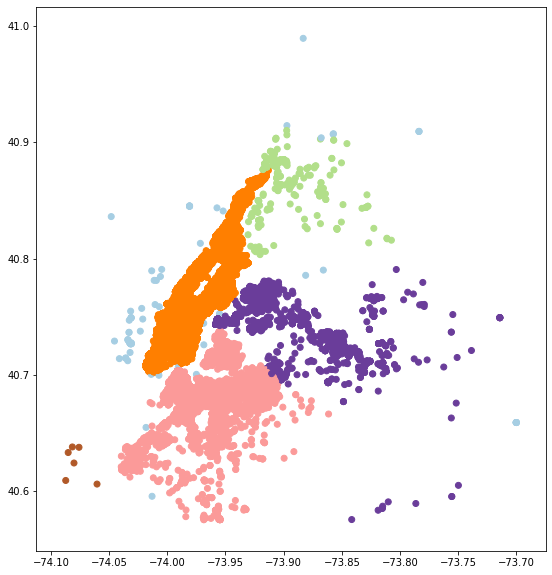

In [276]:
fig, ax = plt.subplots(figsize=(10,10))
gdf.plot("boro_code", cmap="Paired", ax=ax)
plt.show()

### Make an interactive map

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
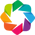

In [322]:
import geoviews as gv
import geoviews.feature as gf
from geoviews import dim, opts
import geoviews.tile_sources as gts
from bokeh.models import HoverTool
gv.extension('bokeh')

In [331]:
data_for_geoviews = gv.Dataset(data_for_modeling, kdims=['boro_name', 'ntaname', "price"])

points = data_for_geoviews.to(gv.Points, ['longitude', 'latitude'], ['boro_name', 'ntaname',"price"])

hover = HoverTool(tooltips = [
            ('Borough', '@boro_name'),
            ('Neighborhood', '@ntaname'),
            ('Monthly rental price, USD', '$@price/month'),
           ])

In [334]:
(tiles.CartoLight() * points).opts(opts.Points(width=800, height=800, color="boro_name", cmap="Category10", tools=[hover], xaxis=None, yaxis=None, title="NYC Apartment Rentals by Borough, Spring 2016"))

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [longitude,latitude]   (boro_name,ntaname,price)

In [335]:
figure = (tiles.CartoLight() * points).opts(opts.Points(width=800, height=800, color="boro_name", cmap="Category10", tools=[hover], toolbar=None, xaxis=None, yaxis=None, title="NYC Apartment Rentals by Borough, Spring 2016"))

In [337]:
gv.save(figure, "nyc_rentals_spring_2016.png", dpi=300)